# VQE on Qnexus using native gates
This notebook aims to run VQE on quantinuum to provide a warm start for DBQA.

## Contents

1. [VQE ansatz circuit](#VQE_ansatz)<br>

# 1. VQE ansatz circuit
First, we look at an example circuit taken from qibo's AVVQE example (hdw_efficient)
and for better compilation results, we replace the $CX$ gates with the native $RZZ$.

In [1]:
from pytket import Circuit, OpType
from datetime import datetime

from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter
from pytket.utils.operators import QubitPauliOperator
from pytket.partition import measurement_reduction, MeasurementBitMap, MeasurementSetup, PauliPartitionStrat
from pytket.backends.backendresult import BackendResult
from pytket.pauli import Pauli, QubitPauliString
from pytket.circuit import Qubit

from scipy.optimize import minimize
import numpy as np
from numpy import ndarray
from numpy.random import random_sample
from sympy import Symbol
from copy import copy
from qibo import hamiltonians
from qibo.symbols import X, Y, Z

import qnexus as qnx
import matplotlib.pyplot as plt

In [2]:
def substitute_ansatz_circuit(symbolic_circuit, params):
    assert len(params) == len(symbolic_circuit.free_symbols())
    symbol_dict = {s: p for s, p in zip(symbolic_circuit.free_symbols(), params)}
    state_prep_circuit = symbolic_circuit.copy()
    state_prep_circuit.symbol_substitution(symbol_dict)
    return state_prep_circuit

def unitary_expectation(H, U=None, ket0=None):
    if ket0 is None:
        ket0 = np.zeros((H.shape[0],), dtype=complex)
        ket0[0] = 1.0
    if U is None:
        psi = ket0
    else:
        psi = U @ ket0
    return np.vdot(psi, H @ psi).real

In [3]:
def hdw_ansatz(nqubits, nlayers=1):
    """
    Constructs a hardware-efficient ansatz circuit for VQE using pytket with symbolic parameters.

    Args:
        nqubits (int): Number of qubits in the circuit.
        nlayers (int, optional): Number of ansatz layers to apply. Defaults to 1.

    Returns:
        tuple:
            - Circuit: A pytket Circuit object with symbolic parameters.
            - dict: A dictionary mapping parameter names to Symbol objects.
    """
    # Initialize the circuit with the specified number of qubits
    circuit = Circuit(nqubits)
    
    # Dictionary to store symbolic parameters
    theta_symbols = {}
    
    for layer in range(nlayers):
        # Apply parameterized RY and RZ gates to each qubit
        for q in range(nqubits):
            # Create unique symbol names for each gate
            ry_name = f"ry_layer{layer}_q{q}"
            rz_name = f"rz_layer{layer}_q{q}"
            
            # Create Symbol objects
            ry_theta = Symbol(ry_name)
            rz_theta = Symbol(rz_name)
            
            # Add the symbols to the dictionary
            theta_symbols[ry_name] = ry_theta
            theta_symbols[rz_name] = rz_theta
            
            # Add RY and RZ gates with symbolic parameters
            circuit.Ry(ry_theta, q).Rz(rz_theta, q)
        
        # Apply ZZ gates in a nearest-neighbor pattern for even starting pairs
        for q in range(0, nqubits - 1, 2):
            # Create symbol name
            zz_name = f"zz_layer{layer}_q{q}"
            # Create Symbol object
            zz_theta = Symbol(zz_name)
            # Add object to dictionary
            theta_symbols[zz_name] = zz_theta
            circuit.ZZPhase(zz_theta, q, q + 1)
        # Apply ZZ gates in a nearest-neighbor pattern for odd starting pairs
        for q in range(1, nqubits-1, 2):
            # Create symbol name
            zz_name = f"zz_layer{layer}_q{q}"
            # Create Symbol object
            zz_theta = Symbol(zz_name)
            # Add object to dictionary
            theta_symbols[zz_name] = zz_theta
            circuit.ZZPhase(zz_theta, q, q + 1)
        # Add ZZ to the first and last qubit
        zz_name = f"zz_layer{layer}_qboundary"
        zz_theta = Symbol(zz_name)
        theta_symbols[zz_name] = zz_theta
        circuit.ZZPhase(zz_theta, 0, nqubits-1)

    # Additional layer of RY and RZ gates (Optional?)
    for q in range(nqubits):
        final_ry_name = f"add_ry_q{q}"
        final_rz_name = f"add_rz_q{q}"
        
        final_ry_theta = Symbol(final_ry_name)
        final_rz_theta = Symbol(final_rz_name)
        
        theta_symbols[final_ry_name] = final_ry_theta
        theta_symbols[final_rz_name] = final_rz_theta
        
        circuit.Ry(final_ry_theta, q)
        circuit.Rz(final_rz_theta, q)
    
    return circuit, theta_symbols

## 1.1 2-qubit VQE

We start with the simple case where there are only 2 qubits.

In [49]:
symbols = [Symbol(f"p{i}") for i in range(5)]
symbolic_circuit = Circuit(2)
symbolic_circuit.X(0)
symbolic_circuit.Ry(symbols[0], 0).Ry(symbols[1], 1)
symbolic_circuit.ZZPhase(symbols[4],0, 1)
symbolic_circuit.Ry(symbols[2], 0).Ry(symbols[3], 0)

[X q[0]; Ry(p1) q[1]; Ry(p0) q[0]; ZZPhase(p4) q[0], q[1]; Ry(p2) q[0]; Ry(p3) q[0]; ]

In [56]:
symbolic_circuit.free_symbols()

{p0, p1, p2, p3, p4}

In [51]:
# render_circuit_jupyter(symbolic_circuit)

In [54]:
# Hamiltonian definition
# XXZ model
delta = 0.5
term_sum = {}
term_sum.update({QubitPauliString({Qubit(0): Pauli.X, Qubit(1): Pauli.X}): 1})
term_sum.update({QubitPauliString({Qubit(0): Pauli.Y, Qubit(1): Pauli.Y}): 1})
term_sum.update({QubitPauliString({Qubit(0): Pauli.Z, Qubit(1): Pauli.Z}): delta})
H = QubitPauliOperator(term_sum)


### 1.1.1 Numerical optimisation

In [66]:
# build zero state
zero_state = np.zeros(4)
# initial params
params_len = len(symbols)
# fix numpy seed to ensure replicability of the experiment
seed = 10
np.random.seed(seed)
initial_params = np.random.uniform(-np.pi, np.pi, params_len)
print('Initial parameters:', initial_params)
# h hamiltonian
h_qibo = hamiltonians.SymbolicHamiltonian(X(0)*X(1) + Y(0)*Y(1) + delta * Z(0)*Z(1))
target_energy = np.real(np.min(np.asarray(h_qibo.eigenvalues())))
# initial energy
c = substitute_ansatz_circuit(symbolic_circuit, initial_params)
initial_energy = unitary_expectation(h_qibo.matrix, c.get_unitary())
print('Target enegry:', target_energy)
print('Initial energy:', initial_energy)
print('Net difference:', initial_energy-target_energy)

[Qibo 0.2.13|WARNING|2025-01-28 12:14:57]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


Initial parameters: [ 1.70475788 -3.01120431  0.83973663  1.5632809  -0.00938072]
Target enegry: -2.5
Initial energy: 0.047693865228487134
Net difference: 2.5476938652284873


In [88]:
def objective_function(params):
    c = substitute_ansatz_circuit(symbolic_circuit, params)
    return unitary_expectation(h_qibo.matrix, c.get_unitary())

In [93]:
max_iter = 5000
result = minimize(
    objective_function,
    initial_params,
    method="COBYLA",
    options={"disp": True, "maxiter": max_iter},
    tol=1e-2,
)

print(result.fun)
print(result.x)

-0.9987466001683154
[ 3.00294715 -2.50201638  0.69213563  1.26051867 -0.05162762]

   Normal return from subroutine COBYLA

   NFVALS =   43   F =-9.987466E-01    MAXCV = 0.000000E+00
   X = 3.002947E+00  -2.502016E+00   6.921356E-01   1.260519E+00  -5.162762E-02


### 1.1.2 VQE optimization on Qnexus emulator

In [68]:

# Computing Expectation Values for Pauli-Strings
def compute_expectation_paulistring(
    distribution: dict[tuple[int, ...], float], bitmap: MeasurementBitMap
) -> float:
    value = 0
    for bitstring, probability in distribution.items():
        value += probability * (sum(bitstring[i] for i in bitmap.bits) % 2)
    return ((-1) ** bitmap.invert) * (-2 * value + 1)

def compute_expectation_value(
    results: list[BackendResult],
    measurement_setup: MeasurementSetup,
    operator: QubitPauliOperator,
) -> float:
    energy = 0
    for pauli_string, bitmaps in measurement_setup.results.items():
        string_coeff = operator.get(pauli_string, 0.0)
        if string_coeff > 0:
            for bm in bitmaps:
                index = bm.circ_index
                distribution = results[index].get_distribution()
                value = compute_expectation_paulistring(distribution, bm)
                energy += complex(value * string_coeff).real
    return energy

In [69]:
# 4. Building our Objective function

class Objective:
    def __init__(
        self,
        symbolic_circuit: qnx.circuits.CircuitRef,
        problem_hamiltonian: QubitPauliOperator,
        n_shots_per_circuit: int,
        target: qnx.BackendConfig,
        iteration_number: int = 0,
        n_iterations: int = 10,
    ) -> None:
        """Returns the objective function needed for a variational
        procedure.
        """
        terms = [term for term in problem_hamiltonian._dict.keys()]
        self._symbolic_circuit: Circuit = symbolic_circuit.download_circuit()
        self._hamiltonian: QubitPauliOperator = problem_hamiltonian
        self._nshots: int = n_shots_per_circuit
        self._measurement_setup: MeasurementSetup = measurement_reduction(
            terms, strat=PauliPartitionStrat.CommutingSets
        )
        self._iteration_number: int = iteration_number
        self._niters: int = n_iterations
        self._target = target


    def __call__(self, parameter: ndarray) -> float:
        value = self._objective_function(parameter)
        self._iteration_number += 1
        if self._iteration_number >= self._niters:
            self._iteration_number = 0
        return value
    
    def _objective_function(
        self,
        parameters: ndarray,
    ) -> float:
        
        # Prepare the parameterised state preparation circuit
        assert len(parameters) == len(self._symbolic_circuit.free_symbols())
        symbol_dict = {s: p for s, p in zip(self._symbolic_circuit.free_symbols(), parameters)}
        state_prep_circuit = self._symbolic_circuit.copy()
        state_prep_circuit.symbol_substitution(symbol_dict)

        # Label each job with the properties associated with the circuit.
        properties = {str(sym): val for sym, val in symbol_dict.items()} | {"iteration": self._iteration_number}

        with qnx.context.using_properties(**properties):

            circuit_list = self._build_circuits(state_prep_circuit)

            # Execute circuits with Nexus
            results = qnx.execute(
                name=f"execute_job_VQE_{datetime.now()}_{self._iteration_number}",
                circuits=circuit_list,
                n_shots=[self._nshots]*len(circuit_list),
                backend_config=self._target,
                timeout=None,
            )

        expval = compute_expectation_value(
            results, self._measurement_setup, self._hamiltonian
        )
        return expval

    def _build_circuits(self, state_prep_circuit: Circuit) -> list[qnx.circuits.CircuitRef]:
        # Requires properties to be set in the context
        
        # Upload the numerical state-prep circuit to Nexus
        qnx.circuits.upload(
            circuit=state_prep_circuit,
            name=f"state prep circuit {self._iteration_number}",
        )
        circuit_list = []
        for mc in self._measurement_setup.measurement_circs:
            c = state_prep_circuit.copy()
            c.append(mc)
            # Upload each measurement circuit to Nexus with correct params
            measurement_circuit_ref = qnx.circuits.upload(
                circuit=c, 
                name=f"state prep circuit {self._iteration_number}",
            )
            circuit_list.append(measurement_circuit_ref)

        # Compile circuits with Nexus
        compiled_circuit_refs = qnx.compile(
            name=f"compile_job_VQE_{datetime.now()}_{self._iteration_number}",
            circuits=circuit_list,
            optimisation_level=2,
            backend_config=self._target,
            timeout=None,
        )
            
        return compiled_circuit_refs

In [70]:
# connect to nexus account
qnx.client.auth.login()

🌐 Browser log in initiated.


╭────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                        │
│         Confirm that the browser shows the following code and click 'allow device':    │
│                                                                                        │
│                                      Z_OtEF                                            │
│                                                                                        │
╰────────────────────────────────────────────────────────────────────────────────────────╯

Browser didn't open automatically? Use this link: https://nexus.quantinuum.com/auth/device/browser?otp=Z_OtEFtnqCDPD3yfkDXjJXEqZ_YG6aPYE6Uk6zcqqVWmD0ydxtlrdwFBpUwYyOlWicEtr1rq6QcRYpFDHTBqPg
✅ Successfully logged in as xiaoyue.li@ntu.edu.sg using the browser.


In [71]:
# set up the project
project_ref = qnx.projects.create(
    name=f"VQE_example_{str(datetime.now())}",
    description="VQE on qnexus",
)

# set this in the context
qnx.context.set_active_project(project_ref)

In [72]:
qnx.projects.add_property(
    name="iteration", 
    property_type="int", 
    description="The iteration number in my dihydrogen VQE experiment", 
)

# Set up the properties for the symbolic circuit parameters
for sym in symbolic_circuit.free_symbols():
    qnx.projects.add_property(
        name=str(sym), 
        property_type="float",
        description=f"VQE {str(sym)} parameter", 
    )

In [73]:
# Upload our ansatz circuit

ansatz_ref = qnx.circuits.upload(
    circuit=symbolic_circuit,
    name="ansatz_circuit",
    description="The ansatz state-prep circuit for my dihydrogen VQE",
)

In [74]:
objective = Objective(
    symbolic_circuit = ansatz_ref,
    problem_hamiltonian = H,
    n_shots_per_circuit = 500,
    n_iterations= 4,
    target = qnx.QuantinuumConfig(device_name="H1-1LE")
)

In [75]:
initial_parameters = random_sample(len(symbolic_circuit.free_symbols()))

result = minimize(
    objective,
    initial_parameters,
    method="COBYLA",
    options={"disp": True, "maxiter": objective._niters},
    tol=1e-2,
)

print(result.fun)
print(result.x)

-0.3459999999999999

[1.22479665 0.19806286 0.76053071 0.16911084 0.08833981]
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =    4   F =-3.460000E-01    MAXCV = 0.000000E+00
   X = 1.224797E+00   1.980629E-01   7.605307E-01   1.691108E-01   8.833981E-02


In [77]:
print('2 qubits target energy:', target_energy)
print('initial_energy:', initial_energy)
print('VQE energy:', result.fun)

2 qubits target energy: -2.5
initial_energy: 0.047693865228487134
VQE energy: -0.3459999999999999


# 2 n-qubit VQE

## 2.1 n-qubit VQE ansatz

In [8]:
nqubits = 10
delta = 0.5
# h hamiltonian
# XXZ
# h_sym = sum([X(i)*X(i+1)+ Y(i)*Y(i+1) + delta* Z(i)*Z(i+1) for i in range(nqubits-1)]
#             +[X(0)*X(nqubits-1)+ Y(0)*Y(nqubits-1) + delta* Z(0)*Z(nqubits-1)])
# TLFIM 2ZZ + Z + X
h_sym = sum([2 * X(i)*X(i+1) + Z(i) + X(i) for i in range(nqubits-1)]
            + [Z(nqubits-1)+ X(nqubits-1)])

h_qibo = hamiltonians.SymbolicHamiltonian(h_sym)
print(len(h_qibo.matrix[0]))
target_energy = np.real(np.min(np.asarray(h_qibo.eigenvalues())))
# create VQE ansatz circuit
symbolic_circuit, symbols = hdw_ansatz(nqubits)
# build zero state
zero_state = np.zeros(2**nqubits)
# initial params
params_len = len(symbols)
# fix numpy seed to ensure replicability of the experiment
seed = 10
np.random.seed(seed)
initial_params = np.random.uniform(-np.pi, np.pi, params_len)
print('Initial parameters:', initial_params)
# initial energy
c = substitute_ansatz_circuit(symbolic_circuit, initial_params)
initial_energy = unitary_expectation(h_qibo.matrix, c.get_unitary())
print('Target enegry:', target_energy)
print('Initial energy:', initial_energy)
print('Net difference:', initial_energy-target_energy)

[Qibo 0.2.13|WARNING|2025-02-20 11:48:08]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


1024
Initial parameters: [ 1.70475788 -3.01120431  0.83973663  1.5632809  -0.00938072 -1.72915367
 -1.89712697  1.63696274 -2.07903793 -2.58653723  1.16465009  2.84875441
 -3.11678496  0.07660625  1.96425543  0.70702213  1.39332975 -1.30768123
  2.62495223  1.34821941  0.26731415 -2.2483119  -0.79582348  1.09411377
 -0.36547294 -0.41460231  0.73995175  0.08255001  0.94497336  0.63484647
  1.91777391  0.13601307  2.56761664 -1.13577315 -2.5732198  -1.25223848
 -2.42540779  2.06516568 -2.84693439  0.79348555  0.29899264  2.00613936
 -1.8915684   2.24215658 -0.93209396  1.59999863 -1.28201041  2.41234405
 -1.09634271 -2.10476719]
Target enegry: -19.723843776575386
Initial energy: -0.7298029566337461
Net difference: 18.994040819941638


In [9]:
def vqe_loss(h_unitary, symbolic_circuit, params):
    c = substitute_ansatz_circuit(symbolic_circuit, params)
    return unitary_expectation(h_unitary, c.get_unitary())

In [10]:
objective = lambda params: vqe_loss(h_qibo.matrix, symbolic_circuit, params)

In [11]:
max_iter = 5000
result = minimize(
    objective,
    initial_params,
    method="COBYLA",
    options={"disp": True, "maxiter": max_iter},
    tol=1e-2,
)

print(result.fun)
print(result.x)

-19.65620030139378

[ 1.63142419 -1.99818387  0.77235768  2.34211989  0.8500121  -1.65648154
 -1.39800302  2.61160682 -1.93760884 -2.53971864  1.95506469  2.95770636
 -3.43084816  1.3362534   2.06478647  0.90003808  1.46482506 -1.34898281
  3.71625067  1.99274849  1.05294732 -2.00940564 -0.00548242  1.39167814
 -1.01255414 -0.55388366  0.76307372  0.35413451  0.89008223  0.62118333
  2.99658636 -0.16603006  3.02161388 -0.66280483 -1.75509214 -1.24187195
 -2.38704631  2.01476947 -2.81634006  0.31509631  0.5469717   2.10635554
 -2.01080846  2.01102194 -0.87637253  2.67018814 -1.38836259  2.43015838
 -1.32691881 -1.98040674]
   Normal return from subroutine COBYLA

   NFVALS =  847   F =-1.965620E+01    MAXCV = 0.000000E+00
   X = 1.631424E+00  -1.998184E+00   7.723577E-01   2.342120E+00   8.500121E-01
      -1.656482E+00  -1.398003E+00   2.611607E+00  -1.937609E+00  -2.539719E+00
       1.955065E+00   2.957706E+00  -3.430848E+00   1.336253E+00   2.064786E+00
       9.000381E-01   1.46482

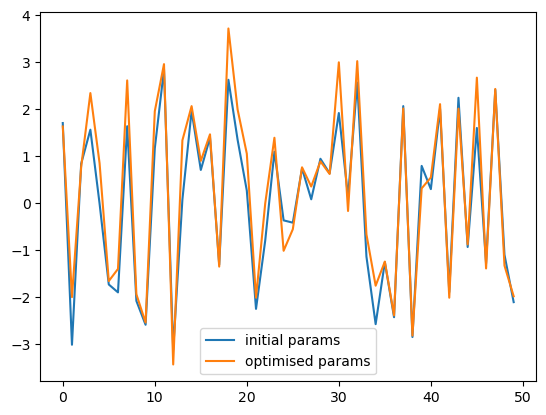

In [12]:
plt.plot(initial_params, label="initial params")
plt.plot(result.x, label='optimised params')
plt.legend()

In [13]:
import os
optimizer = 'cobyla'
nlayer = 1
nqubits = 10
folder_path = f'results/vqe_training/{optimizer}_{nqubits}q_{nlayer}l_TLFIM'
os.makedirs(folder_path, exist_ok=True)
path_param = folder_path + f'/vqe_params.npy'
np.save(path_param, result.x)

In [15]:
vqe_param_file = f'results/vqe_training/{optimizer}_{nqubits}q_{nlayer}l_TLFIM/vqe_params.npy'
vqe_param = np.load(vqe_param_file)

In [16]:
vqe_circ = substitute_ansatz_circuit(symbolic_circuit, vqe_param)

In [17]:
unitary_expectation(h_qibo.matrix, vqe_circ.get_unitary())

-19.65620030139378

In [34]:
from pytket.qasm import circuit_to_qasm_str
folder_path = f'results/circuit_qasm/{optimizer}_{nqubits}q_{nlayer}l_XXZ/'
os.makedirs(folder_path, exist_ok=True)
with open(folder_path + f"vqe_circ.qasm", "w") as file:
    file.write(circuit_to_qasm_str(vqe_circ))

## 1.3 2-layer VQE


In [27]:
nqubits = 10
delta = 0.5
# h hamiltonian
h_sym = sum([X(i)*X(i+1)+ Y(i)*Y(i+1) + delta* Z(i)*Z(i+1) for i in range(nqubits-1)]
            +[X(0)*X(nqubits-1)+ Y(0)*Y(nqubits-1) + delta* Z(0)*Z(nqubits-1)])
h_qibo = hamiltonians.SymbolicHamiltonian(h_sym)
target_energy = np.real(np.min(np.asarray(h_qibo.eigenvalues())))
# create VQE ansatz circuit
ansatz_2vqe, symbols = hdw_ansatz(nqubits, nlayers=2)
# build zero state
zero_state = np.zeros(2**nqubits)
# initial params
params_len = len(symbols)
# fix numpy seed to ensure replicability of the experiment
seed = 10
np.random.seed(seed)
initial_params = np.random.uniform(-np.pi, np.pi, params_len)
print('Initial parameters:', initial_params)
# initial energy
c = substitute_ansatz_circuit(ansatz_2vqe, initial_params)
initial_energy = unitary_expectation(h_qibo.matrix, c.get_unitary())
print('Target enegry:', target_energy)
print('Initial energy:', initial_energy)
print('Net difference:', initial_energy-target_energy)

[Qibo 0.2.13|WARNING|2025-01-31 13:36:29]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


Initial parameters: [ 1.70475788 -3.01120431  0.83973663  1.5632809  -0.00938072 -1.72915367
 -1.89712697  1.63696274 -2.07903793 -2.58653723  1.16465009  2.84875441
 -3.11678496  0.07660625  1.96425543  0.70702213  1.39332975 -1.30768123
  2.62495223  1.34821941  0.26731415 -2.2483119  -0.79582348  1.09411377
 -0.36547294 -0.41460231  0.73995175  0.08255001  0.94497336  0.63484647
  1.91777391  0.13601307  2.56761664 -1.13577315 -2.5732198  -1.25223848
 -2.42540779  2.06516568 -2.84693439  0.79348555  0.29899264  2.00613936
 -1.8915684   2.24215658 -0.93209396  1.59999863 -1.28201041  2.41234405
 -1.09634271 -2.10476719 -0.67525868 -2.5543638   2.01756635 -2.1918765
 -0.72813039  2.79137238  3.06384122 -0.27454663  2.04909026 -1.56216239
  0.61180411  2.5310666   0.217134    0.56675188 -2.89477803 -0.89735348
 -2.64136886 -1.22233138 -1.06362193  1.72052649 -2.89052154 -0.44301371
 -1.16284876  0.85759914 -0.96542933 -2.87080398  2.38707744  1.65398939
  2.37565127 -0.51830534]
Target

In [28]:
def vqe_loss(h_unitary, symbolic_circuit, params):
    c = substitute_ansatz_circuit(symbolic_circuit, params)
    return unitary_expectation(h_unitary, c.get_unitary())

objective = lambda params: vqe_loss(h_qibo.matrix, ansatz_2vqe, params)

In [30]:
max_iter = 5000
result = minimize(
    objective,
    initial_params,
    method="COBYLA",
    options={"disp": True, "maxiter": max_iter},
    tol=1e-2,
)

print(result.fun)
print(result.x)

-13.959802855199758
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS = 5000   F =-1.395980E+01    MAXCV = 0.000000E+00
   X = 1.233318E+00  -3.022022E+00   1.709951E+00   1.789992E+00  -1.347305E-01
      -1.568634E+00  -1.806963E+00   2.698078E+00  -1.323857E+00  -2.606238E+00
       2.503832E+00   2.710220E+00  -3.215680E+00   1.125104E-01   1.884022E+00
       8.183310E-01   1.522451E+00  -1.435094E+00   2.863745E+00   1.196389E+00
       3.711573E-01  -1.524919E+00  -7.091734E-02   7.871992E-01  -4.411924E-01
       1.547947E-02   1.533181E+00   5.019914E-01   9.101623E-01   5.829293E-01
       3.099731E+00  -1.623641E-01   3.037508E+00  -8.482016E-01  -2.611847E+00
      -1.582000E-01  -2.543902E+00   2.041771E+00  -2.839246E+00   4.917471E-01
      -1.319311E-01   1.689394E+00  -1.860574E+00   1.927461E+00  -8.199666E-01
       2.272721E+00  -9.429751E-01   2.430673E+00  -1.214517E+00  -1.468621E+00
      -7.047509E-01  -2.535555E+00   2.5856